In [0]:
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
drive.mount('/gdrive')

# parameters
img_width, img_height = 224, 224  # dimensions to which the images will be resized
batch_size = 32
num_classes = 6  #categories of trash

project_dir = '/gdrive/My Drive/trash-cnn/'
trainset_dir = project_dir+'dataset-splitted/training-set'
testset_dir = project_dir+'dataset-splitted/test-set'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False)



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras import backend as K
from keras import optimizers, regularizers, Model
from keras.applications import densenet

# Generate model using a pretrained architecture substituting the fully connected layer
def generate_transfer_model(input_shape, num_classes):

    # imports the pretrained model and discards the fc layer
    base_model = densenet.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling='max') #using max global pooling, no flatten required

    # train only the top layers, i.e. freeze all convolutional layers
#     for layer in base_model.layers:
#        layer.trainable = False

    # unfreeze last convolutional block
#     train_last_conv_layer = True
#     if train_last_conv_layer:
#         n_layers_unfreeze = (7*16+3+7*24+4) #last two conv 
#         for layer in base_model.layers[-n_layers_unfreeze:]:
#             layer.trainable = True

    # add fc layers
    x = base_model.output
    #x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="elu", kernel_regularizer=regularizers.l2(0.1))(x)
    x = Dropout(0.6)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation="softmax")(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile model using accuracy to measure model performance and adam optimizer
    #optimizer = optimizers.Adam(lr=0.0001)
    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [0]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

print("generating model")
model = generate_transfer_model(input_shape, num_classes)

generating model


Weights loaded
started fit
Epoch 1/50
67/67 [==============================] - 217s 3s/step - loss: 0.2102 - acc: 0.9935 - val_loss: 1.1799 - val_acc: 0.8490
Epoch 2/50
67/67 [==============================] - 62s 924ms/step - loss: 0.1942 - acc: 0.9935 - val_loss: 1.1607 - val_acc: 0.8542
Epoch 3/50
67/67 [==============================] - 62s 925ms/step - loss: 0.1896 - acc: 0.9958 - val_loss: 1.1456 - val_acc: 0.8568
Epoch 4/50
67/67 [==============================] - 62s 925ms/step - loss: 0.1922 - acc: 0.9944 - val_loss: 1.1789 - val_acc: 0.8542
Epoch 5/50
67/67 [==============================] - 62s 923ms/step - loss: 0.1768 - acc: 0.9963 - val_loss: 1.1716 - val_acc: 0.8594
Epoch 6/50
67/67 [==============================] - 62s 921ms/step - loss: 0.1750 - acc: 0.9949 - val_loss: 1.1588 - val_acc: 0.8568
Epoch 7/50
67/67 [==============================] - 62s 924ms/step - loss: 0.1709 - acc: 0.9953 - val_loss: 1.1497 - val_acc: 0.8542
Epoch 8/50
67/67 [==========================

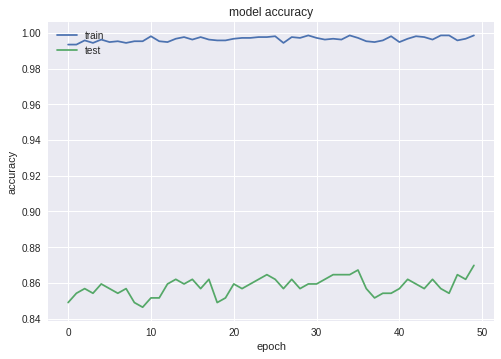

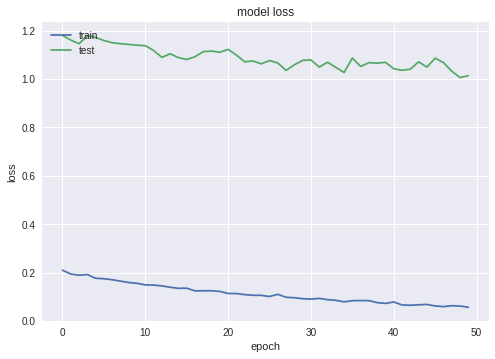

In [28]:
import matplotlib.pyplot as plt
import numpy as np

n_epochs = 50
training_period = 2
load_weights_file = project_dir+'weights_save_{}.h5'.format(training_period)
save_weights_file = project_dir+'weights_save_{}.h5'.format(training_period+1)

def load_weights():
    print("loading weights")
    model.load_weights(load_weights_file)

def fit(n_epochs):
    print("started fit")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=n_epochs,
        validation_data=test_generator,
        validation_steps=len(test_generator))
    
    print("saving")
    model.save_weights(save_weights_file)
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_layers():
    for layer in model.layers:
        print(layer.name)
        print("trainable: "+str(layer.trainable))
        print("input_shape: " + str(layer.input_shape))
        print("output_shape: " + str(layer.output_shape))
        print("_____________")

    

load_weights()
fit(n_epochs)
#print_layers()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd

def print_classification_report():
    # Confution Matrix and Classification Report
    Y_pred = model.predict_generator(test_generator, len(test_generator))
    y_pred = np.argmax(Y_pred, axis=1)

    print('Classification Report')
    target_names = list(test_generator.class_indices.keys())
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    conf_mat = confusion_matrix(test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
#save keras model and convert it into tflite model
def save_model():
    print("saving model")
    
    # Save tf.keras model in HDF5 format.
    keras_file = project_dir+"keras_model.h5"
    model.save(keras_file)

    # Convert to TensorFlow Lite model.
    converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
    tflite_model = converter.convert()
    converted_file = project_dir+"converted_model.tflite"
    open(converted_file, "wb").write(tflite_model)

    print("saved")

load_weights()
print_classification_report()
save_model()